In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBMQの基底ゲート

from fractions import Fraction

In [2]:
# 自作ライブラリ
import made_graph as graph
import operation
import grover_algorithm as algorithm

## 理想的な回路作成

### 動作の確認
初期状態$|0 \cdots 0 \rangle$を作成

In [3]:
# 全体のパラメータ
nqubits = 3
times = 4

In [4]:
import matplotlib.ticker as ticker
state1 = QuantumState(nqubits)
state1.set_zero_state()

次にアダマールゲートを作成する
$$
H = \frac{1}{\sqrt{2}}(|0\rangle \langle 0 | + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

このアダマールゲートを初期状態$|00 \cdots 00\rangle$に作用させる。
$$
|s\rangle = (H\otimes \cdots \otimes H)|0 \cdots 0 \rangle \\
= \frac{1}{(\sqrt{2})^n}(|0\rangle + |1\rangle)\otimes \cdots \otimes (|0\rangle + |1\rangle) \\
= \frac{1}{(\sqrt{2})^n}(|00 \cdots 00\rangle + |00\cdots 01\rangle + \cdots + |11 \cdots 10\rangle + |11\cdots 11\rangle)|s\rangle \\
= \frac{1}{(\sqrt{2})^n}\sum^{2^n - 1}_{x = 0} |x\rangle
$$

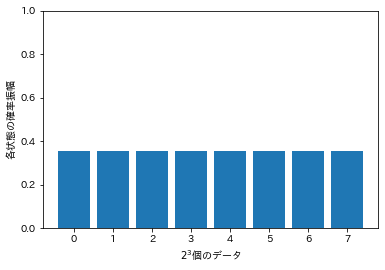

In [6]:
Hadamard = operation.hadamard(nqubits)
Hadamard.update_quantum_state(state1)

graph.show_distribution(state1, nqubits)

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [7]:
fuga = state1.copy()
U_w = operation.make_U_w(nqubits)
U_w.update_quantum_state(fuga)
# print(fuga.get_vector())
print(fuga)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
(-0.353553,0)



最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

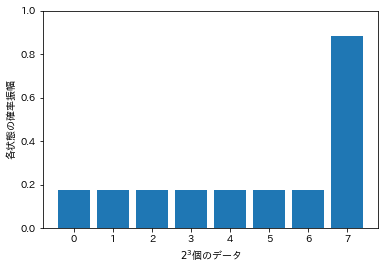

In [8]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

## U_s U_w を作用
U_s = operation.make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)

graph.show_distribution(state1, nqubits)


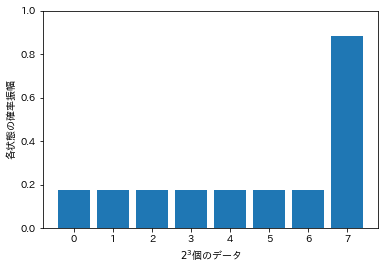

0.8838834764831837


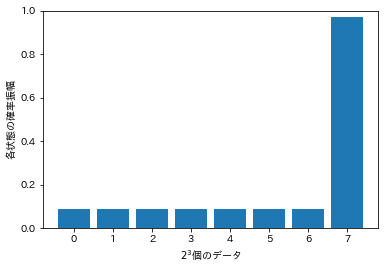

0.9722718241315015


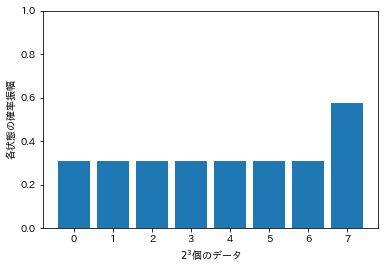

0.5745242597140687


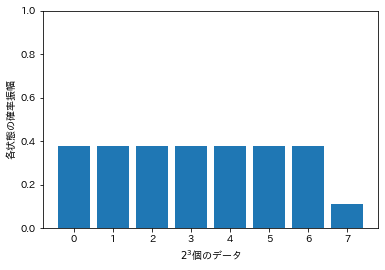

0.11048543456039785


In [9]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state1 = QuantumState(nqubits)
state1.set_zero_state()

Hadamard.update_quantum_state(state1)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    # show_distribution(state1, nqubits)
    graph.show_distribution(state1, nqubits)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785


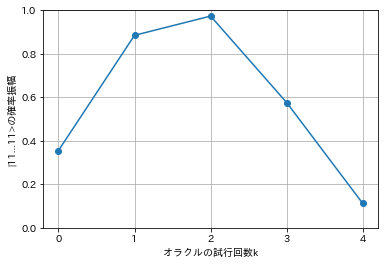

In [10]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

avg_result = []
hoge = np.linalg.norm(inner_product(state1, target_state))
avg_result.append(hoge)
for i in range(times):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, len(avg_result), step=1))
plt.grid()
plt.plot(avg_result, "o-")

maximal probability 9.722718e-01 is obtained at k = 2


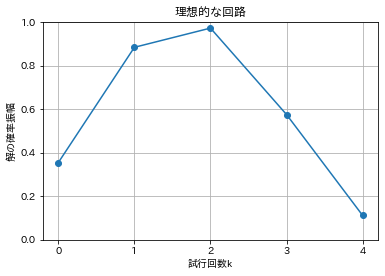

In [11]:
result_array = []
# result_theory, k_theory, p_kth= grover(nqubits, times)
result_theory, k_theory, p_kth = algorithm.grover(nqubits, times)
title = '理想的な回路'
graph.line_graph(result_theory, title)
# line_graph(result_theory, '理想的な回路')

## 任意の回転ゲート
任意の回転ゲートでアダマール演算子を作成する

Qulacsでは任意の回転ゲートを作成する際に、IBMQのOpenQASMを使用する。

以下のコードは、
`U3(対象ビットの添字, \theta, \psi, \lambda)`となっている。
[参考資料](http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id24)
また、対象ビットの添字はQulacsの仕様上、$|00 \cdots 00\rangle$である場合、一番右から0番目の量子ビットになる
[参考資料](https://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html?highlight=%E5%AF%BE%E8%B1%A1%E3%83%93%E3%83%83%E3%83%88%E3%81%AE%E6%B7%BB%E3%81%88%E5%AD%97#id3)

$$
U(\theta, \phi, \lambda) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -e^{i \lambda} \sin{\frac{\theta}{2}} \\
e^{i \phi}\cos{\frac{\theta}{2}} & e^{i (\lambda + \phi)}\cos{\frac{\theta}{2}}
\end{pmatrix}
$$

In [12]:
from qulacs.gate import U3
print(U3(0, np.pi/2, 0, np.pi))

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
           (0.707107,0) (0.707107,-8.65956e-17)
           (0.707107,0) (-0.707107,8.65956e-17)




### 任意の回転ゲートを利用してアダマールゲートを作成
上記の内容を踏まえてアダマールゲートを作成する。
$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\\
= \begin{pmatrix}
\cos{\frac{\pi}{4}} & -e^{i \pi} \sin{\frac{\pi}{4}} \\
e^{i 0}\cos{\frac{\pi}{4}} & e^{i (\pi + 0)}\cos{\frac{\pi}{4}}
\end{pmatrix} \\
= U(\frac{\pi}{2}, 0, \pi)
$$
これを用いて、以下のように作成する。


試しに、通常のアダマール演算子と比較してみる。

通常のアダマールゲート


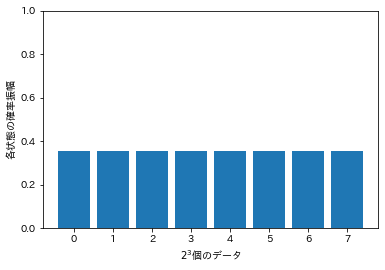

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
作成したアダマールゲート


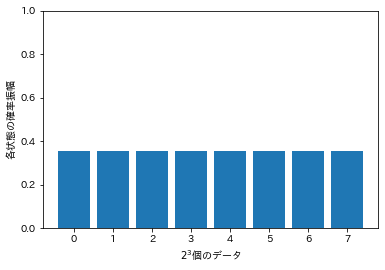

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [14]:
# 通常のアダマール演算子を作成し、 初期化した3量子ビットに作用
Hadamard = operation.hadamard(3)
state1 = QuantumState(3)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)
print('通常のアダマールゲート')
graph.show_distribution(state1, 3)
print(state1.get_vector())

# アダマール演算子と同じ振る舞いをするよう作成した回転ゲートを、
# 初期化した3量子ビットに作用
revolution_Hadamard = operation.make_revolution_Hadamard(3)
state2 = QuantumState(3)
state2.set_zero_state()
revolution_Hadamard.update_quantum_state(state2)
print("作成したアダマールゲート")
graph.show_distribution(state2, 3)

print(state2.get_vector())


どのくらいの誤差があるか調べる。

In [15]:
state1.get_vector() == state2.get_vector()
# 誤差
absolute_error_array = []
relative_error_array = []
for i in range(len(state1.get_vector())):
    absolute_error = state2.get_vector()[i] - state1.get_vector()[i]
    absolute_error_array.append(absolute_error)
    relative_error = absolute_error / state1.get_vector()[i]
    relative_error_array.append(relative_error)

print(f'絶対誤差：{absolute_error_array}')
print(f'相対誤差：{relative_error_array}')


絶対誤差：[(1.6653345369377348e-16+0j), (1.1102230246251565e-16+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (5.551115123125783e-17+0j), 0j]
相対誤差：[(4.710277376051326e-16+0j), (3.140184917367551e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (1.5700924586837754e-16+0j), 0j]


## 任意の回転ゲートを使用してグローバーアルゴリズムを行う。
アダマール演算子と同じ振る舞いをする任意の回転ゲートを使用してグローバーアルゴリズムを行う。

[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]


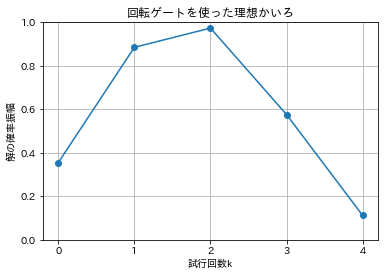

In [16]:
result = []
result, max_k = algorithm.revolution_grover(nqubits, times)
print(result)
title = '回転ゲートを使った理想かいろ'
graph.line_graph(result, title)
# line_graph(result, '回転ゲートを使った理想回路')

In [17]:
grover_result = algorithm.grover(nqubits, times)
print(grover_result)
print(result)

for i in range(len(grover_result)):
    hoge = abs(result[i] - grover_result[i])
    print(f'絶対誤差：{hoge}')


maximal probability 9.722718e-01 is obtained at k = 2
([0.3535533905932737, 0.8838834764831837, 0.9722718241315015, 0.5745242597140687, 0.11048543456039785], 2, 0.9722718241315015)
[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]
絶対誤差：[0.         0.53033009 0.61871843 0.22097087 0.24306796]
絶対誤差：1.116116523516816
絶対誤差：4.440892098500626e-16


## 作成した回転ゲートをずらしていく

作成した回転ゲートのy軸をずらしていく。
変数`delta`には$\theta$に加える角度を示す

### 3量子ビットで計算
実際に、$\delta = 0$~$2\pi$を$\theta$に加える

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


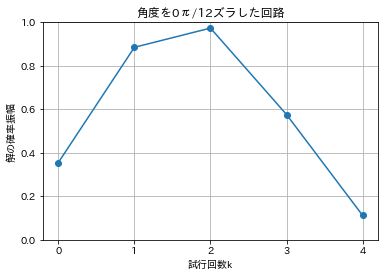

maximal probability 9.722718e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


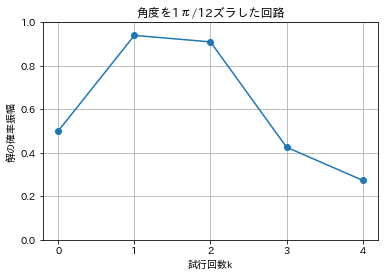

maximal probability 9.387855e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.387855e-01
理想値k_theoryの時の確率:9.088341e-01


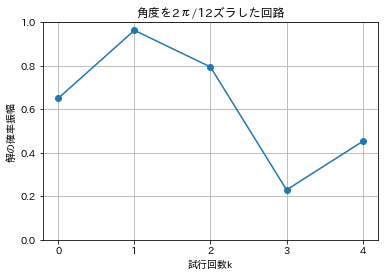

maximal probability 9.620191e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.620191e-01
理想値k_theoryの時の確率:7.935095e-01


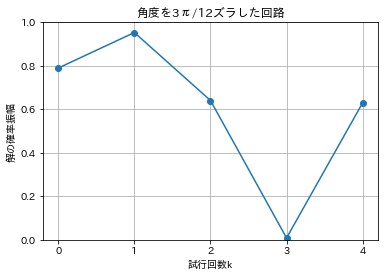

maximal probability 9.519009e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.519009e-01
理想値k_theoryの時の確率:6.392708e-01


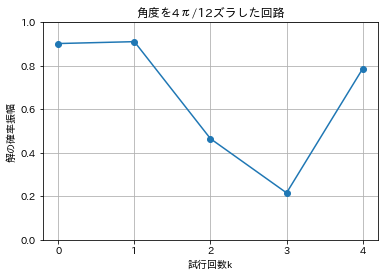

maximal probability 9.098899e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.098899e-01
理想値k_theoryの時の確率:4.636137e-01


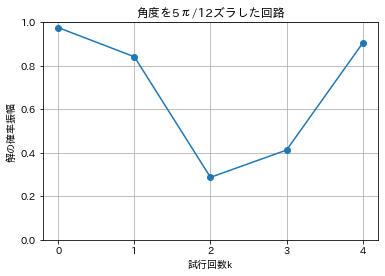

maximal probability 9.745535e-01 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：9.745535e-01
理想値k_theoryの時の確率:2.859961e-01


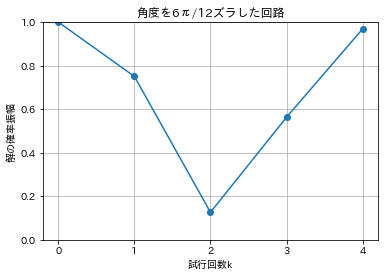

maximal probability 1.000000e+00 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:1.250000e-01


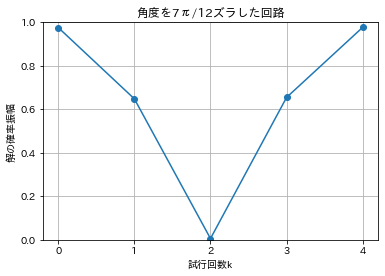

maximal probability 9.756416e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：9.756416e-01
理想値k_theoryの時の確率:4.352187e-03


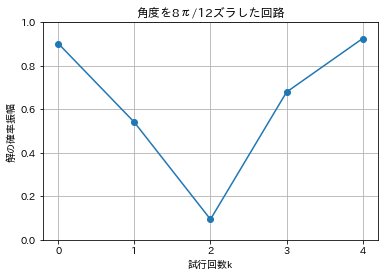

maximal probability 9.244018e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：9.244018e-01
理想値k_theoryの時の確率:9.272274e-02


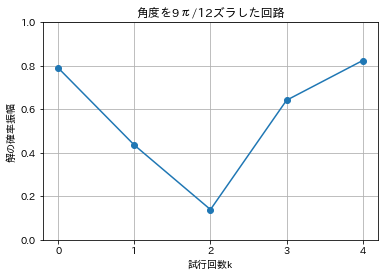

maximal probability 8.230062e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：8.230062e-01
理想値k_theoryの時の確率:1.377029e-01


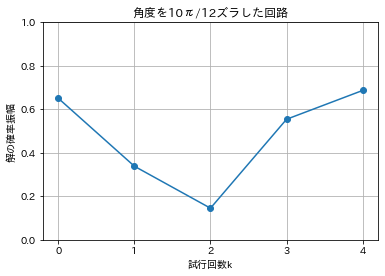

maximal probability 6.855167e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：6.855167e-01
理想値k_theoryの時の確率:1.439905e-01


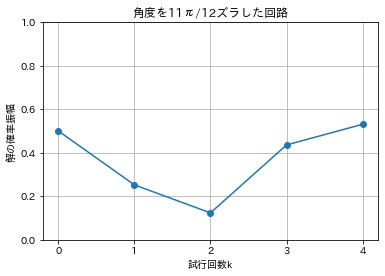

maximal probability 5.299635e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：5.299635e-01
理想値k_theoryの時の確率:1.224774e-01


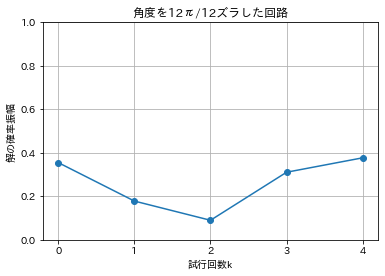

maximal probability 3.756505e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：3.756505e-01
理想値k_theoryの時の確率:8.838835e-02


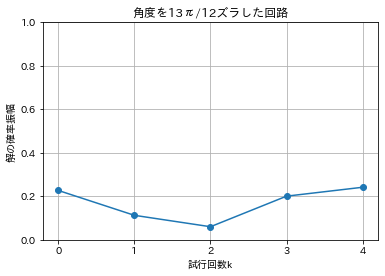

maximal probability 2.402909e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：2.402909e-01
理想値k_theoryの時の確率:5.875898e-02


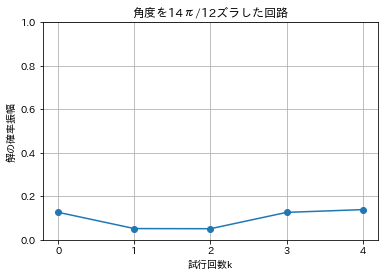

maximal probability 1.374098e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：1.374098e-01
理想値k_theoryの時の確率:4.963929e-02


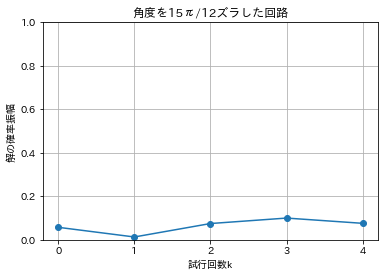

maximal probability 9.857256e-02 is obtained at k = 3
理想値\k_therorとの差:1
実験値kの時の確率：9.857256e-02
理想値k_theoryの時の確率:7.345292e-02


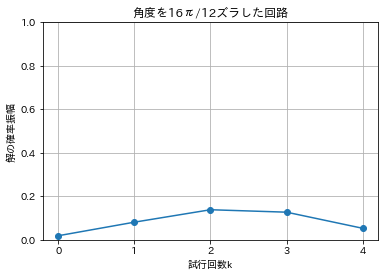

maximal probability 1.369169e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：1.369169e-01
理想値k_theoryの時の確率:1.369169e-01


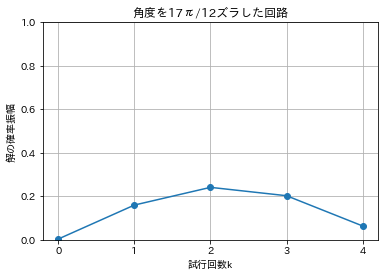

maximal probability 2.398421e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：2.398421e-01
理想値k_theoryの時の確率:2.398421e-01


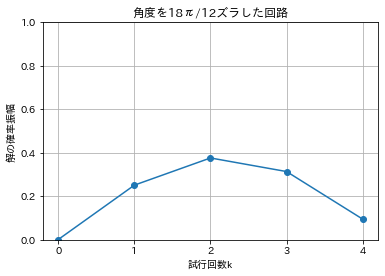

maximal probability 3.750000e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：3.750000e-01
理想値k_theoryの時の確率:3.750000e-01


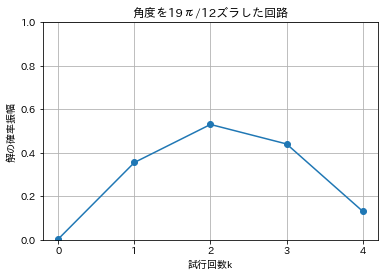

maximal probability 5.290785e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：5.290785e-01
理想値k_theoryの時の確率:5.290785e-01


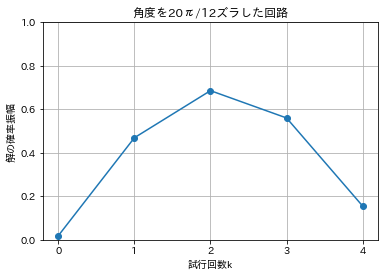

maximal probability 6.845846e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：6.845846e-01
理想値k_theoryの時の確率:6.845846e-01


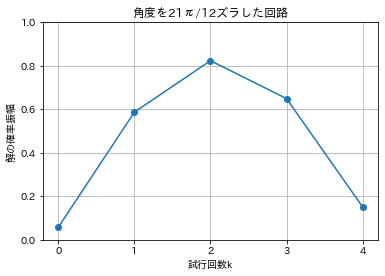

maximal probability 8.224053e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：8.224053e-01
理想値k_theoryの時の確率:8.224053e-01


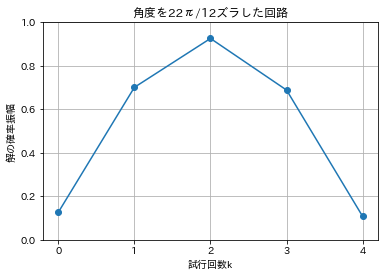

maximal probability 9.246393e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.246393e-01
理想値k_theoryの時の確率:9.246393e-01


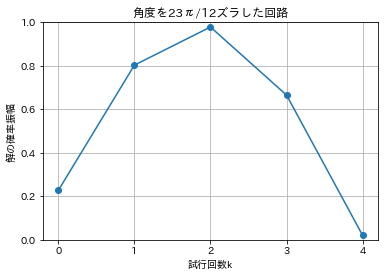

maximal probability 9.772698e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.772698e-01
理想値k_theoryの時の確率:9.772698e-01


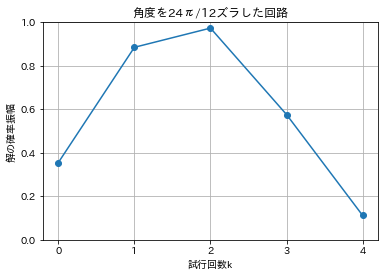

maximal probability 9.722718e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


In [18]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

# noises_title = ['0','', '(π/4)',' ',  'π/2', '  ', '3π/4','   ', 'π', '    ', '5π/4', '     ', '3π/2', '      ', '7π/4', '       ', '2π']

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    graph.line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [19]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

# noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
# noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]


k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # k_k_theory = abs(max_k - k_theory)
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)


#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

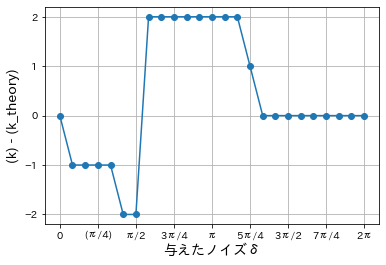

In [20]:
THREEk_k_theory_array = k_k_theory_array
graph.different_of_k_graph(noises, k_k_theory_array, -3, 3)

#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

In [ ]:
THREE_p_k_array = p_k_array
graph.P_k_graph(noises, p_k_array)


#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる


In [ ]:
THREE_p_kth_array = p_kth_array
graph.P_k_throry_graph(noises, p_kth_array)

## 5量子ビットで計算

In [ ]:
nqubits = 5
times = 10

In [ ]:
result_array = []
result_theory, k_theory, p_kth= algorithm.grover(nqubits, times)
graph.line_graph(result_theory, '理想的な回路')

In [ ]:
noises_title = ['0','', '(π/4)',' ',  'π/2', '  ', '3π/4','   ', 'π', '    ', '5π/4', '     ', '3π/2', '      ', '7π/4', '       ', '2π']

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    graph.line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [ ]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # k_k_theory = abs(max_k - k_theory)
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

In [ ]:
FIVE_k_k_theory_array = k_k_theory_array
graph.different_of_k_graph(noises, k_k_theory_array, -5, 7)


#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

In [ ]:
FIVE_p_k_array = p_k_array
graph.P_k_graph(noises, p_k_array)

#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる

In [ ]:
FIVE_p_kth_array = p_kth_array
graph.P_k_throry_graph(noises, p_kth_array)

## 10量子ビットで計算

In [ ]:
nqubits = 10
times = 27

In [ ]:
result_array = []
result_theory, k_theory, p_kth= algorithm.grover(nqubits, times)
graph.line_graph(result_theory, '理想的な回路')

In [ ]:
k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    graph.line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [ ]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

# noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
# noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

In [ ]:
TEN_k_k_theory_array = k_k_theory_array
graph.different_of_k_graph(noises, k_k_theory_array, -27, 1)

#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

In [ ]:
TEN_p_k_array = p_k_array
graph.P_k_graph(noises, p_k_array)

#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる

In [ ]:
TEN_p_kth_array = p_kth_array
graph.P_k_throry_graph(noises, p_kth_array)

## グラフを重ねてみる

#### $k - k_{\text{theory}}$のグラフを重ねてみる

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.set_yticks(np.arange(-27, 8, 1))
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("(k) - (k_theory)", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREEk_k_theory_array, "-o", label = l1)
ax.plot(x, FIVE_k_k_theory_array, "-+", label = l2)
ax.plot(x, TEN_k_k_theory_array, "-x", label = l3)
ax.legend(loc = 0)

#### $P(k)$のグラフ化

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("実験値kの時の確率", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREE_p_k_array, "-o", label = l1)
ax.plot(x, FIVE_p_k_array, "-+", label = l2)
ax.plot(x, TEN_p_k_array, "-x", label = l3)
ax.legend(loc = 0)

#### $P(k_{\text{\theta})$のグラフ化

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("理想値k_theoryの時の確率", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREE_p_kth_array, "-o", label = l1)
ax.plot(x, FIVE_p_kth_array, "-+", label = l2)
ax.plot(x, TEN_p_kth_array, "-x", label = l3)
ax.legend(loc = 0)


## $\frac{\pi}{2}$とその直前直後のグラフ
$\frac{\pi}{2}$とその直前、直後のグラフを作成し、その違いを見てみる

In [ ]:
nqubits = 3
times = 5

result_array = []
# result_theory, k_theory, p_kth= grover(nqubits, times)
result_theory, k_theory, p_kth = algorithm.grover(nqubits, times)
graph.line_graph(result_theory, '理想的な回路')

In [ ]:
noises = []
noises_array = []
n = 24
for i in range(10, 14 + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

for i in range(len(noises)):
    result, max_k, p_k = algorithm.noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # p_k = result[max_k]
    # p_kth = result[k_theory]

    graph.line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

## δ = πの時の状態

In [ ]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
# Hadamard = make_noisy_Hadamard(3, np.pi)
Hadamard = operation.make_noisy_Hadamard(3, np.pi)
Hadamard.update_quantum_state(state1)
# show_distribution(state1, nqubits)
graph.show_distribution(state1, nqubits)

## U_s U_w を作用
# U_s = make_U_s(nqubits)
U_s = operation.make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)
# show_distribution(state1, nqubits)
graph.show_distribution(state1, nqubits)

for _ in range(4):
    # U_s = make_U_s(nqubits)
    U_s = operation.make_U_s(nqubits)
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    # show_distribution(state1, nqubits)
    graph.show_distribution(state1, nqubits)
